In [30]:
## Paquetes
import pandas as pd
import xarray as xr
import rioxarray
from pyproj import CRS
from rasterio.enums import Resampling
from scipy.ndimage import uniform_filter, distance_transform_edt, generic_filter
import numpy as np
from xrspatial import slope, aspect
from joblib import load
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
import rasterio as rio

In [6]:
## Functions
def downscale_tmax_with_dem_from_epiweeks(tmax_da, dem_ds, lapse_rate=-6.5):
    """
    Downscaling de tmax por lapse rate usando DEM de alta resolución.
    
    Parámetros:
    - tmax_da: xarray.DataArray con dims ('epi_week', 'y', 'x')
    - dem_ds: xarray.Dataset con variable 'band_data' (DEM de alta resolución)
    - lapse_rate: gradiente térmico en °C/km. Por defecto: -6.5
    
    Retorna:
    - xarray.DataArray de tmax ajustado a resolución fina del DEM
    """

    # 1. Extraer DEM como DataArray
    dem_fine = dem_ds['band_data']

    # 2. Crear DEM de baja resolución con mismo tamaño espacial que tmax
    # Se ajusta usando coarsen si las resoluciones son múltiples
    factor_y = dem_fine.sizes['y'] // tmax_da.sizes['y']
    factor_x = dem_fine.sizes['x'] // tmax_da.sizes['x']
    
    dem_coarse = dem_fine.coarsen(y=factor_y, x=factor_x, boundary="trim").mean()

    # 3. Reinterpolar tmax a la resolución del DEM
    # Suponemos que 'x' e 'y' tienen coordenadas compatibles (ajustar si no)
    tmax_interp = tmax_da.interp(
        x=dem_fine['x'],
        y=dem_fine['y'],
        method='linear'
    )

    # 4. Reinterpolar DEM de baja resolución al tamaño de DEM fino
    dem_coarse_interp = dem_coarse.interp(
        x=dem_fine['x'],
        y=dem_fine['y'],
        method='linear'
    )

    # 5. Calcular diferencia de elevación
    delta_z = dem_fine - dem_coarse_interp

    # 6. Aplicar lapse rate (°C/km → °C/m)
    lapse_rate_per_m = lapse_rate / 1000
    correction = delta_z * lapse_rate_per_m

    # 7. Aplicar corrección a cada epi_week
    corrected = tmax_interp + correction

    return corrected


def calcular_tpi_mascarado(dem_da, size=3):
    elev = dem_da.values.astype(float)
    valid_mask = ~np.isnan(elev)

    elev_filled = np.where(valid_mask, elev, 0)

    sum_neighbors = uniform_filter(elev_filled, size=size, mode='constant', cval=0)
    count_neighbors = uniform_filter(valid_mask.astype(float), size=size, mode='constant', cval=0)

    mean_neighbors = np.where(count_neighbors > 0, sum_neighbors / count_neighbors, np.nan)
    tpi_array = np.where(valid_mask, elev - mean_neighbors, np.nan)

    tpi_da = xr.DataArray(tpi_array, coords=dem_da.coords, dims=dem_da.dims, name='tpi')

    # Aplicar máscara explícita
    return tpi_da.where(valid_mask)


def local_rugosity(arr):
    valid = arr[~np.isnan(arr)]
    return np.nanmax(valid) - np.nanmin(valid) if len(valid) > 0 else np.nan

def predict_from_dataset(ds: xr.Dataset, template_var: str, output_var: str = "predicted_variable") -> xr.Dataset:
    """
    Aplica el modelo entrenado sobre un xarray.Dataset y devuelve uno nuevo con la variable predicha agregada.

    Parámetros:
    - ds: Dataset de entrada con la misma estructura de entrenamiento (puede ser a mayor resolución).
    - template_var: variable base del dataset para conservar la estructura.
    - output_var: nombre de la variable resultante.

    Retorna:
    - Dataset con la nueva variable agregada.
    """

    # Convertir dataset a DataFrame
    df = ds.to_dataframe().reset_index()

    # Filtrar filas que tengan al menos los datos clave
    required_vars = ["chirps_1km", "tmax_saga", "tmin_saga"]
    df = df.dropna(subset=required_vars)
    if df.empty:
        raise ValueError("No hay datos suficientes con chirps_1km, tmax_saga y tmin_saga.")

    # Crear variables temporales
    if "epi_week" in df.columns and df["epi_week"].dtype == object:
        df["week"] = df["epi_week"].str[-2:].astype(int)
        df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
        df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

    # Coordenadas explícitas
    df["Latitud"] = df["y"]
    df["Longitud"] = df["x"]

    # Guardar coordenadas mínimas para reconstrucción
    df_coords = df[["epi_week", "y", "x"]].copy()

    # Eliminar columnas que no sirven para predicción
    drop_cols = ["spatial_ref", "band", "epi_week", "x", "y", "week", "week_cos"]
    df = df.drop(columns=[col for col in drop_cols if col in df.columns])

    # Preparar matriz de features ordenada alfabéticamente
    X = df.reindex(sorted(df.columns), axis=1)
    print("Features usadas:", X.columns.tolist())

    # Predecir
    y_pred = final_model.predict(X)

    # Reconstruir DataArray
    df_coords[output_var] = y_pred
    da_pred = df_coords.set_index(["epi_week", "y", "x"]).to_xarray()[output_var]

    # Plantilla de salida
    template = ds[template_var]
    da_full = xr.full_like(template, np.nan).astype("float64")
    da_full.loc[da_pred.coords] = da_pred

    # Agregar predicción al dataset original
    ds_out = ds.copy()
    ds_out[output_var] = da_full
    return ds_out

## Carga de variables espaciales

In [7]:
# Rutas a los archivos
data_gee = "D:/OneDrive - CGIAR/Desktop/downscaling/data/preprocessed/gee/gee_2013-22_2025-05.nc"
data_c3s = "D:/OneDrive - CGIAR/Desktop/downscaling/data/preprocessed/copernicus/c3s_2013-22_2025-05.nc"
data_chirps = "D:/OneDrive - CGIAR/Desktop/downscaling/data/preprocessed/chirps/chirps_2013-22_2025-05.nc"
data_dem = "D:/OneDrive - CGIAR/Desktop/downscaling/data/auxiliary/DEM/DEM.tif"


modis_crs = CRS.from_proj4(
    "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext"
)

# Cargar como dataset (puede contener múltiples variables)
ds_chirps = xr.open_dataset(data_chirps).rio.write_crs("EPSG:4326", inplace=False)
ds_c3s = xr.open_dataset(data_c3s).rio.write_crs("EPSG:4326", inplace=False).rename({"lat": "y", "lon": "x"})
ds_gee = xr.open_dataset(data_gee).rio.write_crs(modis_crs)
ds_dem = xr.open_dataset(data_dem).squeeze("band").rio.write_crs("EPSG:4326", inplace=False)

# Listar variables disponibles
print("CHIRPS variables:", list(ds_chirps.data_vars))
print("C3S variables:", list(ds_c3s.data_vars))
print("GEE variables:", list(ds_gee.data_vars))
print("DEM variables:", list(ds_dem.data_vars))

CHIRPS variables: ['precip']
C3S variables: ['tmax', 'tmin', 'humidity', 'windspeed']
GEE variables: ['NDVI', 'NDWI']
DEM variables: ['band_data']


In [8]:
# Paso 1: Aplica el filtro para reemplazar por NA valores fuera del rango NDVI
NDVI_filtrado = ds_gee.NDVI.where((ds_gee.NDVI >= -1) & (ds_gee.NDVI <= 1))
# Paso 2: Crea una máscara que identifica *solo* los nuevos NaN (es decir, los que fueron filtrados)
mask_NDVI = NDVI_filtrado.isnull() & ds_gee.NDVI.notnull()
# Paso 3: Interpola
ndvi_step1 = NDVI_filtrado.interpolate_na(dim="y", method="nearest", use_coordinate=False)
NDVI_interpolado = ndvi_step1.interpolate_na(dim="x", method="nearest", use_coordinate=False)
# Paso 4: Reconstruye: deja interpolado solo donde fue filtrado; deja el resto como estaba
NDVI_500m= NDVI_filtrado.where(~mask_NDVI, NDVI_interpolado)

In [9]:
# Paso 1: Aplica el filtro para reemplazar por NA valores fuera del rango NDWI
NDWI_filtrado = ds_gee.NDWI.where((ds_gee.NDWI >= -1) & (ds_gee.NDWI <= 1))
# Paso 2: Crea una máscara que identifica *solo* los nuevos NaN (es decir, los que fueron filtrados)
mask_NDWI = NDWI_filtrado.isnull() & ds_gee.NDWI.notnull()
# Paso 3: Interpola
ndWi_step1 = NDWI_filtrado.interpolate_na(dim="y", method="nearest", use_coordinate=False)
NDWI_interpolado = ndWi_step1.interpolate_na(dim="x", method="nearest", use_coordinate=False)
# Paso 4: Reconstruye: deja interpolado solo donde fue filtrado; deja el resto como estaba
NDWI_500m = NDWI_filtrado.where(~mask_NDWI, NDWI_interpolado)

In [10]:
# Se generan variables a 1 km con resampling 
NDVI_1k = NDVI_500m.rio.reproject_match(ds_dem, resampling=Resampling.nearest)
NDWI_1k = NDWI_500m.rio.reproject_match(ds_dem, resampling=Resampling.nearest)

## Variables DEM

In [11]:
dem_da_meters = ds_dem.band_data.rio.reproject("EPSG:3116")  # MAGNA-SIRGAS / Cali urbana
tpi_da = calcular_tpi_mascarado(dem_da_meters)

# Umbrales TPI (puedes ajustar)
cumbre_mask = (tpi_da > 100).fillna(False).values
valle_mask = (tpi_da < -100).fillna(False).values

dist_cumbre = distance_transform_edt(~cumbre_mask)
dist_valle = distance_transform_edt(~valle_mask)

dist_cumbre_da = xr.DataArray(dist_cumbre, coords=dem_da_meters.coords, dims=dem_da_meters.dims, name='dist_to_cumbre')
dist_valle_da = xr.DataArray(dist_valle, coords=dem_da_meters.coords, dims=dem_da_meters.dims, name='dist_to_valle')
### Pendiente y Aspect
slope_da = slope(dem_da_meters)
aspect_da = aspect(dem_da_meters)
### Rugosity
rugosity_array = generic_filter(dem_da_meters.values, local_rugosity, size=3, mode='nearest')
rugosity_da = xr.DataArray(rugosity_array, coords=dem_da_meters.coords, dims=dem_da_meters.dims, name='rugosity')

C:\Users\dagudelo\AppData\Local\Temp\ipykernel_23940\4266107212.py:62: RuntimeWarning: divide by zero encountered in divide
  mean_neighbors = np.where(count_neighbors > 0, sum_neighbors / count_neighbors, np.nan)
C:\Users\dagudelo\AppData\Local\Temp\ipykernel_23940\4266107212.py:62: RuntimeWarning: invalid value encountered in divide
  mean_neighbors = np.where(count_neighbors > 0, sum_neighbors / count_neighbors, np.nan)


## Temperatura Saga

In [12]:
tmax_11k = ds_c3s.tmax- 273.15
tmin_11k = ds_c3s.tmin - 273.15

tmax_saga =downscale_tmax_with_dem_from_epiweeks(tmax_11k,ds_dem,lapse_rate=-6.5)
tmin_saga = downscale_tmax_with_dem_from_epiweeks(tmin_11k,ds_dem,lapse_rate=-6.5)

## Carga el modelo

In [21]:
# Cargar modelo
final_model = load("D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_precip.joblib")

# Acceder a los nombres de variables
feature_names = model.get_booster().feature_names
print(feature_names)

['Latitud', 'Longitud', 'chirps_1km', 'cumbre', 'ndvi_rugosity', 'ndwi', 'tmax_saga', 'tmin_saga', 'tpi', 'tpi2', 'week_sin']


In [16]:
precip_5k = ds_chirps.precip
precip_1k= precip_5k.rio.reproject_match(NDVI_1k, resampling=Resampling.bilinear)
# Asegúrate de que NDWI y rugosity están alineados espacialmente
# Si las coordenadas 'x' e 'y' son distintas, primero reproyecta o interpola
rugosity_interp = rugosity_da.interp_like(NDVI_1k.isel(epi_week=0))  # interpola solo en x, y

# Expande 'rugosity' para que tenga la dimensión 'epi_week'
rugosity_expanded = rugosity_interp.expand_dims(epi_week=NDVI_1k.epi_week)

# Multiplica usando broadcasting
NDVI_rugosity = NDVI_1k * rugosity_expanded

In [17]:
# 1. Dale un nombre único a cada DataArray
chirps_1km     = precip_1k.rename('chirps_1km')
cumbre_da      = dist_cumbre_da.rename('cumbre')
tmax_saga      = tmax_saga.rename('tmax_saga')
tmin_saga      = tmin_saga.rename('tmin_saga')
NDWI_1k        = NDWI_1k.rename('ndwi')
NDVI_1k        = NDVI_1k.rename('ndvi')
NDVI_rugosity  = NDVI_rugosity.rename('ndvi_rugosity')
tpi_1k         = tpi_da.rename('tpi')
tpi2_1k         = (tpi_da**2).rename('tpi2')

# 2. Verifica que TODOS compartan CRS y la misma malla (dims x/y):
#    Si aún difieren usa rio.reproject_match o interp_like antes de merge.
ref = chirps_1km                      # el raster de referencia

others = [
    cumbre_da.rio.reproject_match(ref),
    tmax_saga.rio.reproject_match(ref),
    tmin_saga.rio.reproject_match(ref),
    NDWI_1k.rio.reproject_match(ref),
    NDVI_rugosity.rio.reproject_match(ref),
    tpi_1k.rio.reproject_match(ref),
    tpi2_1k.rio.reproject_match(ref)
]

# 3. Fusión segura
ds = xr.merge([ref, *others], compat='override')   # ahora s

C:\Users\dagudelo\AppData\Local\Temp\ipykernel_23940\2303517775.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_buffered["geometry"] = gdf_buffered.geometry.buffer(0.004)


<Axes: >

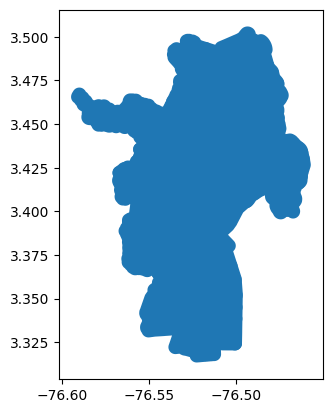

In [18]:
# Cargar shapefile
import geopandas as gdp

shapefile_path = "D:/OneDrive - CGIAR/Desktop/downscaling/data/auxiliary/shapefiles/cali/cali.shp"

gdf = gdp.read_file(shapefile_path).to_crs("EPSG:4326")

gdf_buffered = gdf.copy()
gdf_buffered["geometry"] = gdf_buffered.geometry.buffer(0.004)

gdf_buffered.plot()

In [19]:
data_pred_cali = ds.rio.clip(
    gdf_buffered.geometry.values.tolist(),  # ✅ lista de shapely geometries
    gdf_buffered.crs,
    drop=True,
    invert=False
)

In [22]:
ds_pred = predict_from_dataset(
    ds=data_pred_cali,
    template_var="ndwi",
    output_var="precip_fore"
)

Features usadas: ['Latitud', 'Longitud', 'chirps_1km', 'cumbre', 'ndvi_rugosity', 'ndwi', 'tmax_saga', 'tmin_saga', 'tpi', 'tpi2', 'week_sin']


In [23]:
ds_pred.rio.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [24]:
ds_pred.to_netcdf('D:/OneDrive - CGIAR/Desktop/downscaling/data/predictions/precip_predicted.nc')

## Xgboost Forecast

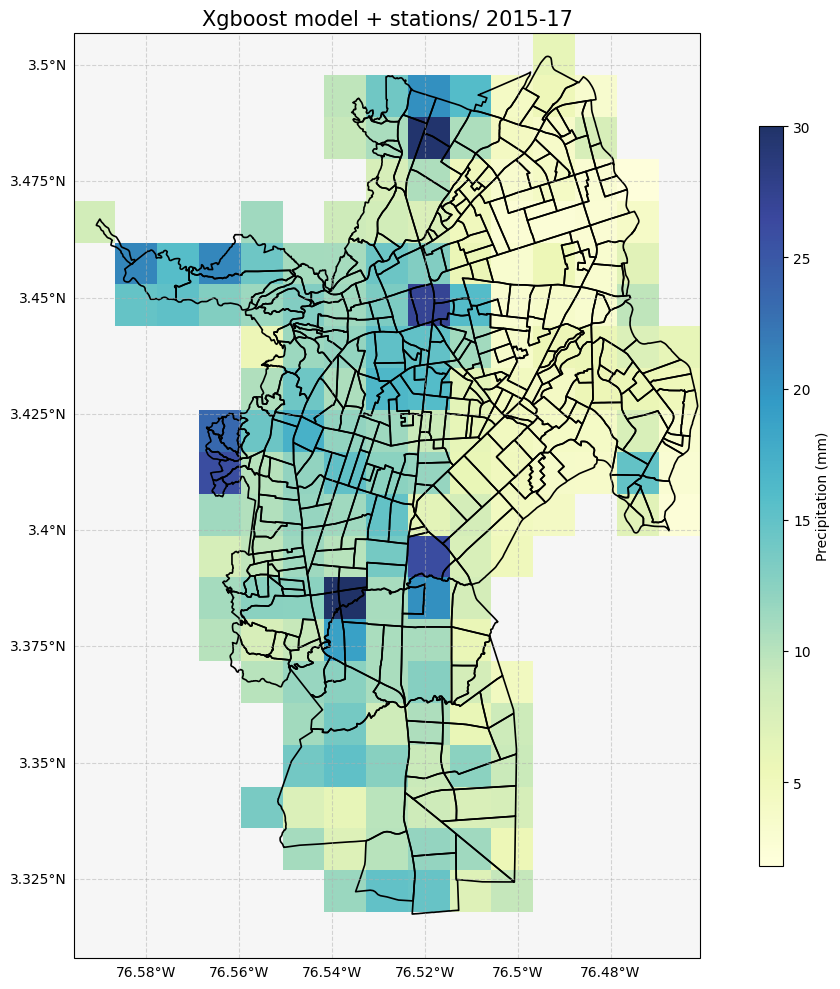

In [34]:

target_da = ds_pred.precip_fore[100, :, :]

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Mapa base
target_da.plot(
    ax=ax,
    cmap='YlGnBu',  # Escala adecuada para precipitación
    add_colorbar=True,
    cbar_kwargs={
        "label": "Precipitation (mm)",
        "shrink": 0.8,
        "aspect": 30
    },
    alpha=0.9,
    zorder=1,
    transform=ccrs.PlateCarree()
)

# Contorno del shapefile
gdf.to_crs(epsg=4326).boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.2,
    zorder=2,
    transform=ccrs.PlateCarree()
)

# Elementos decorativos
ax.coastlines(resolution='10m', color='gray', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, linewidth=0.8)
gl.top_labels = False
gl.right_labels = False

ax.set_title("Xgboost model + stations/ 2015-17", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## Linea base Bilinear CHIRPS

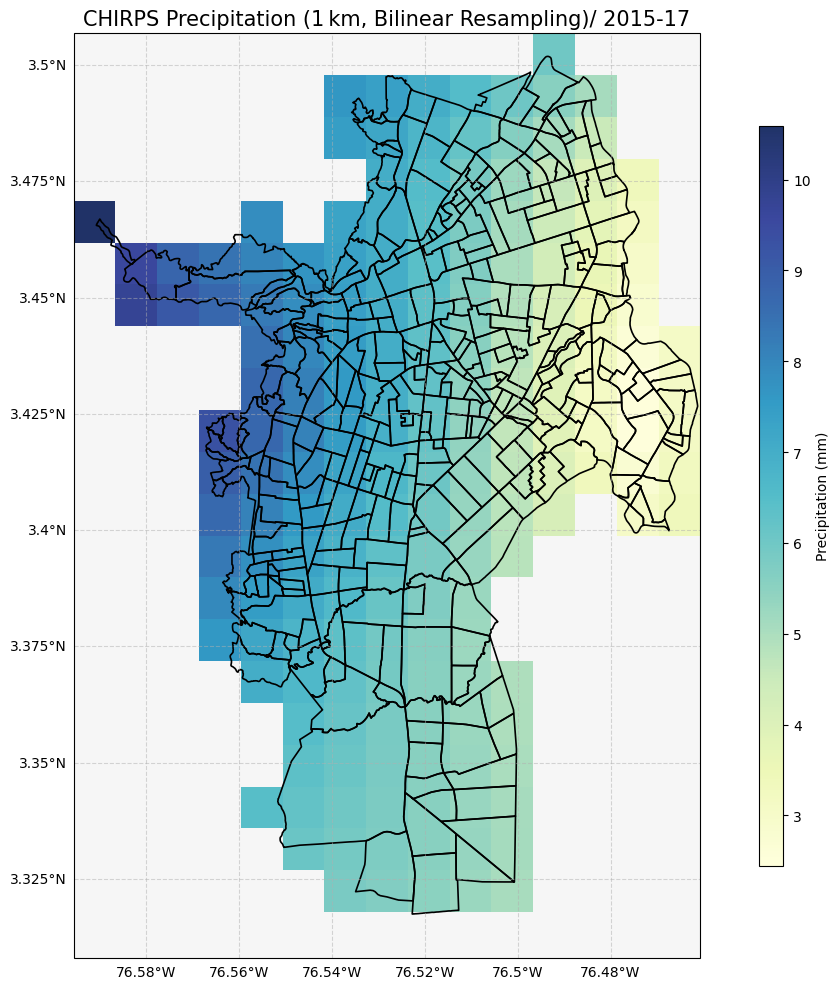

In [35]:

target_da = ds_pred.chirps_1km[100, :, :]

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Mapa base
target_da.plot(
    ax=ax,
    cmap='YlGnBu',  # Escala adecuada para precipitación
    add_colorbar=True,
    cbar_kwargs={
        "label": "Precipitation (mm)",
        "shrink": 0.8,
        "aspect": 30
    },
    alpha=0.9,
    zorder=1,
    transform=ccrs.PlateCarree()
)

# Contorno del shapefile
gdf.to_crs(epsg=4326).boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.2,
    zorder=2,
    transform=ccrs.PlateCarree()
)

# Elementos decorativos
ax.coastlines(resolution='10m', color='gray', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, linewidth=0.8)
gl.top_labels = False
gl.right_labels = False

ax.set_title("CHIRPS Precipitation (1 km, Bilinear Resampling)/ 2015-17", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

## Precipitación CHIRPS

In [ ]:

ejem = precip_5k.rio.reproject_match(tmin_saga,resampling=rio.enums.Resampling.nearest)


precip_5k_cali = ejem.rio.clip(
    gdf_buffered.geometry.values.tolist(),  # ✅ lista de shapely geometries
    gdf_buffered.crs,
    drop=True,
    invert=False
)

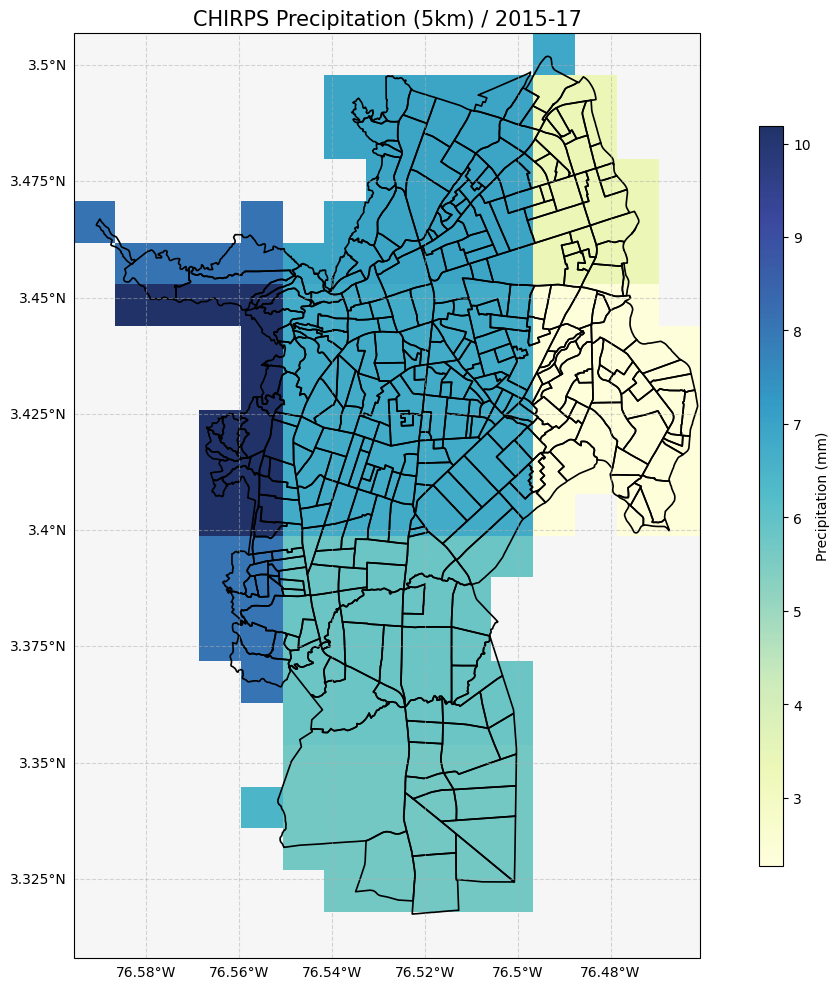

In [32]:

target_da = precip_5k_cali[100, :, :]

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Mapa base
target_da.plot(
    ax=ax,
    cmap='YlGnBu',  # Escala adecuada para precipitación
    add_colorbar=True,
    cbar_kwargs={
        "label": "Precipitation (mm)",
        "shrink": 0.8,
        "aspect": 30
    },
    alpha=0.9,
    zorder=1,
    transform=ccrs.PlateCarree()
)

# Contorno del shapefile
gdf.to_crs(epsg=4326).boundary.plot(
    ax=ax,
    edgecolor='black',
    linewidth=1.2,
    zorder=2,
    transform=ccrs.PlateCarree()
)

# Elementos decorativos
ax.coastlines(resolution='10m', color='gray', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.2)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.1)

gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5, linewidth=0.8)
gl.top_labels = False
gl.right_labels = False

ax.set_title("CHIRPS Precipitation (5km) / 2015-17", fontsize=15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show()